In this notebook we fit the data using maximum likehood approach and determine the parameter uncertainties using the Hessian matrix of the log-likelihood.

In [ ]:
!pip install numdifftools
# Installing an addtional package

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.2/100.2 kB 1.9 MB/s eta 0:00:00


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize
import scipy.stats
import numdifftools # module to do differentiation
# basic imports
import warnings
warnings.simplefilter("ignore")

from IPython import display
%matplotlib inline

In [ ]:
# This program calculates the error-bars of the ML fit by computing
# the second derivatives at the minimum

def model(p, x):
    return (
        p[0] + p[1] * x + 5 * np.sin(x / p[2])
    )

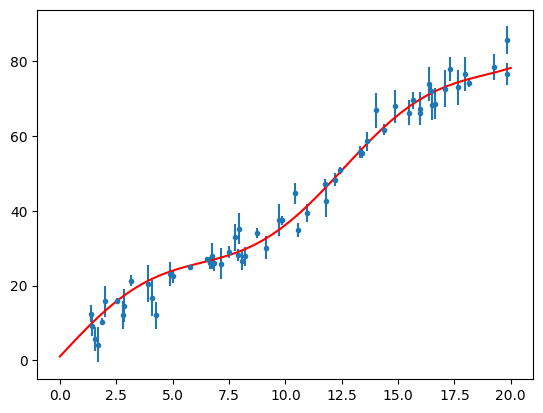

In [ ]:
ptrue = [1, 4, 2]
def gendata(npoints=60):
    # generate the data
    # Our True model 1+ 2 * x + 5 * sin(x/4)

    minx, maxx = 0, 20
    xs = np.random.uniform(minx, maxx, npoints)
    ys = model(ptrue, xs)
    # error-free data

    errs = np.random.uniform(0.5, 5, npoints)

    ys = ys + np.random.normal(size=npoints) * errs
    # perturb the data by the errors

    plt.clf()
    plt.errorbar(xs, ys, errs, fmt='.')
    plt.plot(np.linspace(minx, maxx), model(ptrue, np.linspace(minx, maxx)),
          color='red')
    plt.draw()
    return xs,ys,errs

gendata();

In [ ]:
# log-likelihood function
def like(p, xdat, ydat, errdat):
    # p are the function parameters
    # args carry anything we want to pass to our function (e.g. the data)

    ymod = model(p, xdat)

    lprob =  scipy.stats.norm(ymod,errdat).logpdf(ydat)

    # probabilities of the data under Gaussian distribution
    like = -lprob.sum()

    # print p, like

    return like

In [ ]:
def run(npoints=60):
    # generate the data, fit it and find uncertainties
    xs, ys, errs = gendata(npoints=npoints)

    p0 = [.9, 3.8, 1.5]

    method = 'L-BFGS-B'

    res = scipy.optimize.minimize(like, p0, method=method,
                                  args=(xs, ys, errs))
    pfinal = res.x
    print ('True value', ptrue)
    print ('Measured value', pfinal)
    # pfinal is the location of the minimum of the likelihood

    hess = numdifftools.Hessian(like)  # Hessian function

    hessmat = hess(pfinal, xs, ys, errs)
    # this is the matrix of second derivatives of the log(likelihood)
    # Covariance matrix of the results is given by
    # the inverse of this matrix

    covariance_matrix = np.matrix(hessmat).I # invert the matrix
    errors = np.diagonal(covariance_matrix)**.5
    print ( 'Covariance', covariance_matrix )
    print ( '1D errors', errors )
    # take diagonal elements from the covariance matrix

    return pfinal, errors

In [ ]:
np.random.seed(1) # initialize the random number generator

True value [1, 4, 2]
Measured value [0.79381599 4.02581064 1.97841931]
Covariance [[ 3.69273837e-01 -2.79013064e-02  1.27201536e-03]
 [-2.79013064e-02  2.43222186e-03 -6.71686007e-05]
 [ 1.27201536e-03 -6.71686007e-05  3.17362693e-04]]
1D errors [0.60767906 0.04931756 0.01781468]


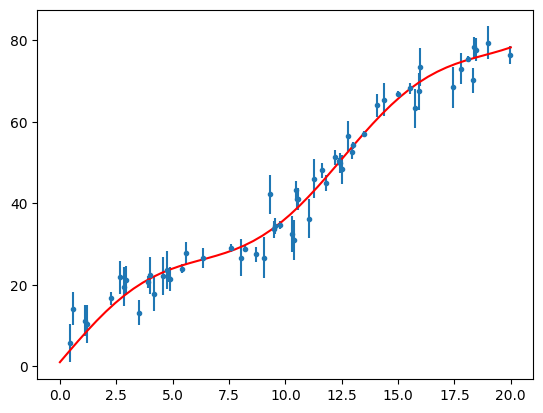

In [12]:
ret = run()

True value [1, 4, 2]
Measured value [0.98214391 4.00156759 1.99886413]
Covariance [[ 1.74241390e-04 -1.33609455e-05  1.29477465e-06]
 [-1.33609455e-05  1.35997404e-06 -2.00035053e-07]
 [ 1.29477465e-06 -2.00035053e-07  3.84013323e-07]]
1D errors [0.01320005 0.00116618 0.00061969]


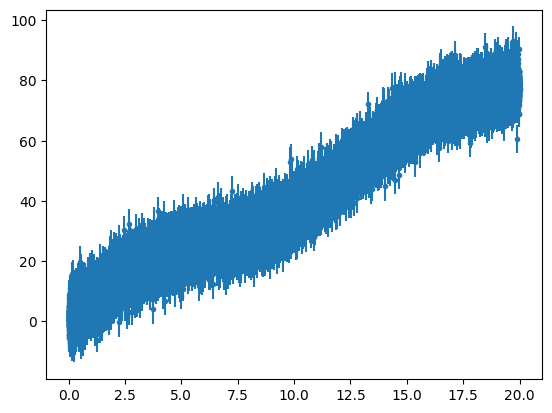

In [13]:
ret = run(60000)

In [14]:
def check_errors(ndat = 60):

    # check the errorbars on the parameters from the ML procedure
    # by running repeated fits
    # and plotting the distribution of (measurement - true value)/error
    niterations = 40

    results = np.zeros((niterations, 3))
    errors = np.zeros((niterations, 3))
    # create empty array to hold the parameters and the errors
    for i in range(niterations):
        np.random.seed(i)
        val, error = run(ndat)
        results[i, :] = val
        errors[i, :] = error

    xgrid = np.linspace(-5, 5, 100)
    bin = 0.75
    bins = int(10./bin)
    fig=plt.figure(figsize=(5,5))
    fig.add_subplot(311)
    plt.hist((results[:, 0] - ptrue[0]) / errors[:, 0], range=[-5,5],
             bins=bins)
    # plot the histogram of the (measument - true value)/error

    plt.plot(xgrid, scipy.stats.norm.pdf(xgrid) * niterations * bin,
          color='red')
    # overplot the Gaussian

    #plt.subplot(312)
    fig.add_subplot(312)
    plt.hist((results[:, 1] - ptrue[1]) / errors[:, 1],
             range=[-5,5],bins=bins)
    plt.plot(xgrid, scipy.stats.norm.pdf(xgrid) * niterations * bin, color='red')

    #plt.subplot(313)
    fig.add_subplot(313)

    plt.hist((results[:, 2] - ptrue[2]) / errors[:, 2],
             range=[-5,5], bins=bins)
    plt.plot(xgrid, scipy.stats.norm.pdf(xgrid) * niterations * bin, color='red')
    plt.xlabel('(Meas-True)/errorbar')
    #plt.draw()
    return results, errors


True value [1, 4, 2]
Measured value [1.58932487 4.0026685  2.03349148]
Covariance [[ 2.29305305e-01 -1.68490416e-02  1.56273826e-03]
 [-1.68490416e-02  1.49226833e-03 -8.72326058e-05]
 [ 1.56273826e-03 -8.72326058e-05  2.69668742e-04]]
1D errors [0.47885833 0.03862989 0.01642159]
True value [1, 4, 2]
Measured value [1.49493928 3.99513532 1.98982906]
Covariance [[ 0.12263633 -0.00931588  0.00125964]
 [-0.00931588  0.00113184 -0.00022433]
 [ 0.00125964 -0.00022433  0.00038841]]
1D errors [0.3501947  0.03364286 0.01970814]
True value [1, 4, 2]
Measured value [1.18197472 3.98101991 2.05072644]
Covariance [[ 1.76675659e-01 -1.71139526e-02  2.46273914e-04]
 [-1.71139526e-02  2.26972502e-03  3.38449550e-05]
 [ 2.46273914e-04  3.38449550e-05  9.82607670e-04]]
1D errors [0.42032804 0.04764163 0.03134657]
True value [1, 4, 2]
Measured value [1.01376726 3.99590397 1.98358497]
Covariance [[ 0.21103721 -0.01972698 -0.00200855]
 [-0.01972698  0.00243064  0.00043666]
 [-0.00200855  0.00043666  0.0006

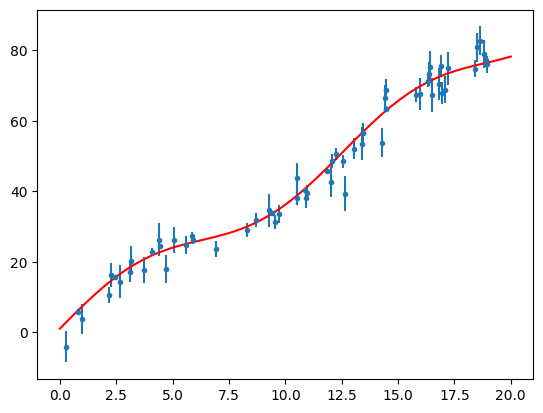

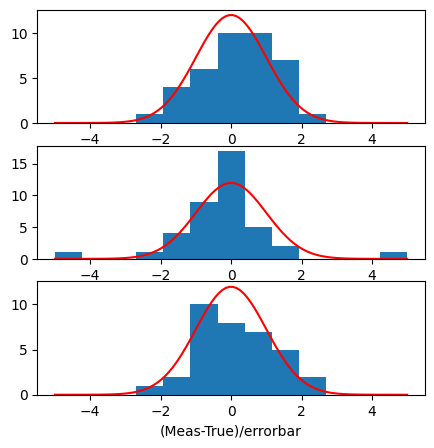

In [15]:
ret = check_errors()